# Profile

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

datadir = '../kingston'
libdir = '.'
outputdir = '.'
otherdir = '.'

train_bs_ = 16 # train_batch_size
valid_bs_ = 32 # valid_batch_size
num_workers_ = 5

# CFG

In [5]:
class CFG:
    seed=42
    device='GPU'
    nprocs=1 
    num_workers=num_workers_
    train_bs=train_bs_
    valid_bs=valid_bs_
    fold_num=5 
    
    target_cols=["C1", "C2", "C3", "C4", "C5", "C6", "C7", "OT"]
    num_classes=8 
    
    accum_iter=1 
    max_grad_norm=1000 
    print_freq=100 
    normalize_mean=[0.4824, 0.4824, 0.4824] 
    normalize_std=[0.22, 0.22, 0.22] 
    
    suffix="109" 
    fold_list=[0] 
    epochs=15
    model_arch="efficientnet-b0"
    img_size=320 
    optimizer="AdamW" 
    scheduler="CosineAnnealingLR"
    loss_fn="BCEWithLogitsLoss"
    scheduler_warmup= "GradualWarmupSchedulerV3"

    warmup_epo=1
    warmup_factor = 10
    T_max= epochs-warmup_epo-2 if scheduler_warmup=="GradualWarmupSchedulerV2" else \
           epochs-warmup_epo-1 if scheduler_warmup=="GradualWarmupSchedulerV3" else epochs-1
   
    lr=5e-3 
    min_lr=1e-6 #
    weight_decay=0 
    
    n_early_stopping=5

# Import

In [6]:
# !pip install -q git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
    
import sys; 

package_paths = [f'{libdir}pytorch-image-models-master']
for pth in package_paths:
    sys.path.append(pth)
    
import ast
from glob import glob
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm
from contextlib import contextmanager
import math

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
import timm
import warnings
import joblib
from scipy.ndimage.interpolation import zoom
import nibabel as nib
import pydicom as dicom
import gc 


if CFG.device == 'TPU':
    !pip install -q pytorch-ignite
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

/home/xuming/anaconda3/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# helper

In [13]:
train_df = pd.read_csv(f'{datadir}/seg_25d.csv')
print('train_df shape:', train_df.shape)
train_df.head(3)

train_df shape: (29658, 6)


,id,StudyInstanceUID,slice_num,image_path,mask_path,fold
0,1.2.826.0.1.3680043.9926_1,1.2.826.0.1.3680043.9926,1,seg_25d_image/1.2.826.0.1.3680043.9926_1.npy,seg_25d_image/1.2.826.0.1.3680043.9926_1.npy,1
1,1.2.826.0.1.3680043.9926_2,1.2.826.0.1.3680043.9926,2,seg_25d_image/1.2.826.0.1.3680043.9926_2.npy,seg_25d_image/1.2.826.0.1.3680043.9926_2.npy,1
2,1.2.826.0.1.3680043.9926_3,1.2.826.0.1.3680043.9926,3,seg_25d_image/1.2.826.0.1.3680043.9926_3.npy,seg_25d_image/1.2.826.0.1.3680043.9926_3.npy,1


0 ---> background   
1 ---> C1   
2 ---> C2   
...     
8 ---> T1 - T12  

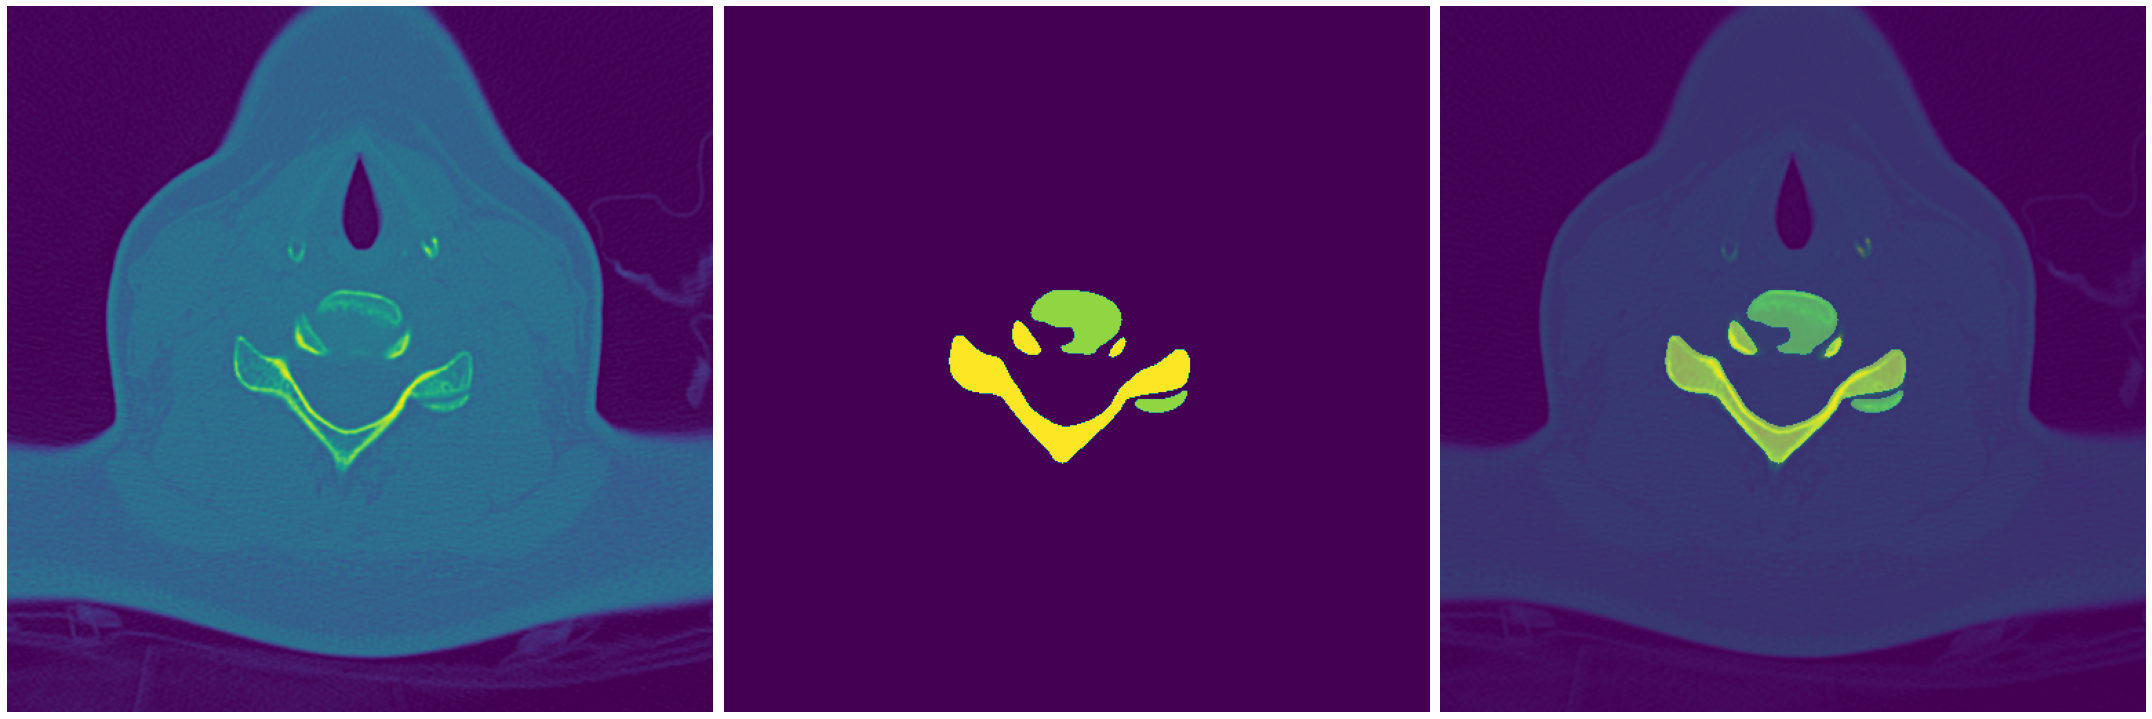

In [6]:
example_name = "1.2.826.0.1.3680043.780_147"
image_example = np.load(f"{datadir}/seg_25d_image/{example_name}.npy").transpose(2,0,1)
mask_example = np.load(f"{datadir}/seg_25d_mask/{example_name}.npy").transpose(2,0,1)
plt.figure(figsize=(30, 20))
plt.subplot(1, 3, 1); plt.imshow(image_example[1]); plt.axis('OFF');
plt.subplot(1, 3, 2); plt.imshow(mask_example[1]); plt.axis('OFF');
plt.subplot(1, 3, 3); plt.imshow(image_example[1]); plt.imshow(mask_example[1],alpha=0.5); plt.axis('OFF');
# plt.colorbar()
plt.tight_layout()
plt.show()

In [7]:
if CFG.device == 'TPU':
    import os
    VERSION = "1.7"
    CP_V = "36" if ENV == "colab" else "37"
    wheel = f"torch_xla-{VERSION}-cp{CP_V}-cp{CP_V}m-linux_x86_64.whl"
    url = f"https://storage.googleapis.com/tpu-pytorch/wheels/{wheel}"
    !pip3 -q install cloud-tpu-client==0.10 $url
    os.system('export XLA_USE_BF16=1')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.train_bs = CFG.train_bs // CFG.nprocs
    device = xm.xla_device()
elif CFG.device == "GPU":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)


def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')

# 日志记录函数
def init_logger(log_file=outputdir+'/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger(outputdir+f'/train{CFG.suffix}.log')

if CFG.device=='TPU' and CFG.nprocs==8:
    loginfo = xm.master_print
    cusprint = xm.master_print
else:
    loginfo = LOGGER.info
    cusprint = print

def get_result(result_df):
    preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
    labels = result_df[CFG.target_cols].values
    score, scores = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')


def get_timediff(time1,time2):
    minute_,second_ = divmod(time2-time1,60)
    return f"{int(minute_):02d}:{int(second_):02d}"  


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb


def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img

# Dataset

In [9]:
# 构造 dataset类
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        image = np.load(f"{datadir}/seg_25d_image/{file_name}.npy") # 512 * 512 * 3
        mask = np.load(f"{datadir}/seg_25d_mask/{file_name}.npy") # 512 * 512 * 3

        # transform
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        image = image/255.0


        real_mask = np.zeros([CFG.num_classes, CFG.img_size, CFG.img_size])  # 8 * img_size * img_size
        for idx in range(CFG.num_classes):
            mask_bool = (mask[:,:,1] == (idx+1))
            real_mask[idx] = mask_bool 
        
        image = np.transpose(image, (2, 0, 1)) # 3 * img_size * img_size
        mask = np.transpose(mask, (2, 0, 1)) # 3 * img_size * img_size

        return torch.from_numpy(image), torch.from_numpy(real_mask), torch.from_numpy(mask)

In [10]:
# 图像AUG策略
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform
)
import albumentations

from albumentations.pytorch import ToTensorV2

def get_transforms(data):
    if data == 'train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                            min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ], p=1.0)

    elif data == 'light_train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            # VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                # OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            # CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
            #              min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ], p=1.0)

    elif data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ])

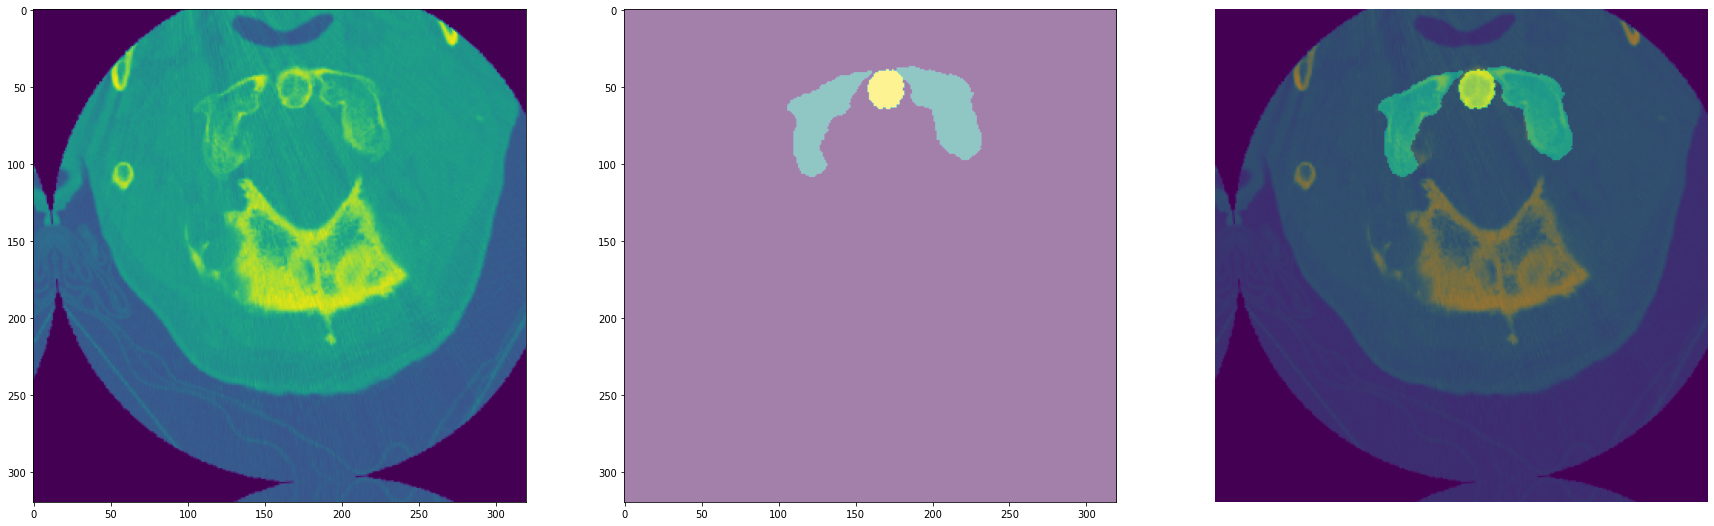

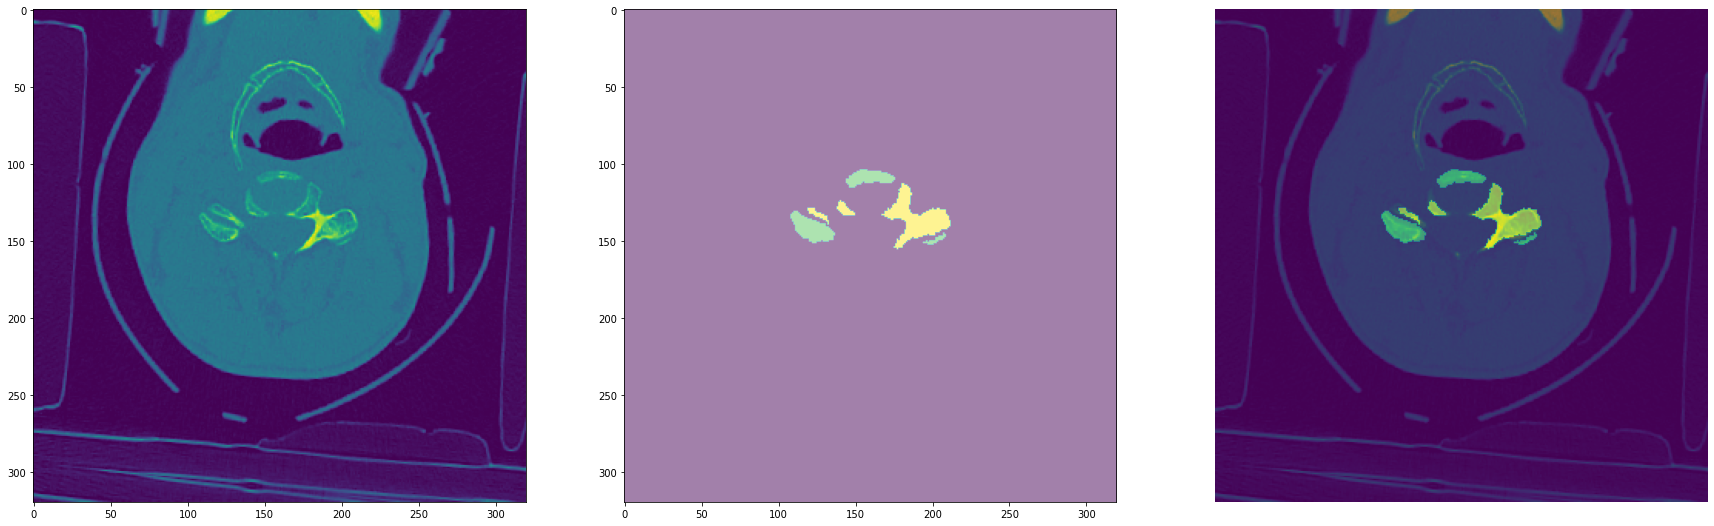

In [11]:
# 图像示例
from pylab import rcParams
dataset_show = TrainDataset(
    train_df, 
    get_transforms("light_train") # None, get_transforms("train")
    )
rcParams['figure.figsize'] = 30,20
for i in range(2):
    f, axarr = plt.subplots(1,3)
    idx = np.random.randint(0, len(dataset_show))
    img, mask, raw_mask = dataset_show[idx]
    # axarr[p].imshow(img) # transform=None
    axarr[0].imshow(img[1]); plt.axis('OFF');
    axarr[1].imshow(raw_mask[1]/255, alpha=0.5); plt.axis('OFF');
    axarr[2].imshow(img[1]); axarr[2].imshow(raw_mask[1]/255,alpha=0.5); plt.axis('OFF');

# Model

In [12]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.model_arch,    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [13]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice


In [14]:
def train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    model.train()
    start = end = time.time()
    for step, (images, masks, raw_mask) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)
        batch_size = images.size(0)

        if CFG.device == 'GPU':
            with autocast(enabled=True):
                y_preds = model(images)
                loss = criterion(y_preds, masks)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        elif CFG.device == 'TPU':
            y_preds = model(images)
            loss = criterion(y_preds, masks)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            cusprint('Epoch: [{0}][{1}/{2}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                'Grad: {grad_norm:.4f}  '
                'LR: {lr:.7f}  '
                .format(
                epoch, step, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(train_loader)),
                grad_norm=grad_norm,
                lr=optimizer.param_groups[0]["lr"],
                ))

    return losses.avg, optimizer.param_groups[0]["lr"]

In [15]:
def valid_one_epoch(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    start = end = time.time()
    val_scores = []
    for step, (images, masks, raw_mask) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)
        batch_size = images.size(0)
        # compute loss
        with torch.no_grad():
            y_pred = model(images)
        loss = criterion(y_pred, masks)
        losses.update(loss.item(), batch_size)

        # record accuracy
        y_pred = y_pred.sigmoid() ####
        # y_pred = y_pred.sigmoid().to('cpu').numpy()
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice])

        if CFG.accum_iter > 1:
            loss = loss / CFG.accum_iter
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            cusprint('EVAL: [{0}/{1}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                step, len(valid_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(valid_loader)),
                ))

    val_scores = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    return losses.avg, val_scores

# loss & optimizer & scheduler

In [16]:
# 自定义逐渐升温调度器
class GradualWarmupSchedulerV3(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV3, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch >= self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

# Training

In [17]:
# 训练函数
def train_loop(df, fold):
    loginfo(f"========== fold: {fold} training ==========")
    # ====================================================
    # loader 
    # ====================================================
    train_folds = train_df[train_df["fold"] != fold].reset_index(drop=True)
    valid_folds = train_df[train_df["fold"] == fold].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='light_train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='valid'))
    if CFG.device == 'GPU':
        train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=True, num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
    elif CFG.device == 'TPU':
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=True)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG.train_bs, sampler=train_sampler, drop_last=True, num_workers=CFG.num_workers)
        valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=False)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=CFG.valid_bs, sampler=valid_sampler, drop_last=False, num_workers=CFG.num_workers)

    # ====================================================
    # model & optimizer & scheduler & loss 
    # ====================================================
    model = build_model()

    # optimizer
    if CFG.optimizer == "AdamW":
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            optimizer = AdamW(model.parameters(), lr=CFG.lr/CFG.warmup_factor, weight_decay=CFG.weight_decay) 
        else:
            optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)  
    # scheduler
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)

    if CFG.scheduler_warmup=="GradualWarmupSchedulerV3":
        scheduler_warmup = GradualWarmupSchedulerV3(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)

    # loss
    def criterion(y_pred, y_true):
        return 0.5*BCELoss(y_pred, y_true) + 0.5*DiceLoss(y_pred, y_true)

    # ====================================================
    # loop 
    # ====================================================

    valid_acc_max=0
    valid_acc_max_cnt=0
    for epoch in range(CFG.epochs):
        loginfo(f"***** Epoch {epoch} *****")
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            pass
            # loginfo(f"schwarmup_last_epoch:{scheduler_warmup.last_epoch}, schwarmup_lr:{scheduler_warmup.get_last_lr()[0]}")
        if CFG.scheduler=='CosineAnnealingLR':
            loginfo(f"scheduler_last_epoch:{scheduler.last_epoch}, scheduler_lr:{scheduler.get_last_lr()[0]}")
        loginfo(f"optimizer_lr:{optimizer.param_groups[0]['lr']}")
                
        start_time = time.time() # 记录当前时间

        # train
        if CFG.device == 'TPU' and CFG.nprocs == 8:
            para_train_loader = pl.ParallelLoader(train_loader, [device])
            avg_loss, cur_lr = train_one_epoch(para_train_loader.per_device_loader(device), model, criterion, optimizer, epoch, scheduler, device)
        else:
            avg_loss, cur_lr = train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # valid
        if CFG.device == 'TPU' and CFG.nprocs == 8:
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            avg_val_loss, valid_scores = valid_one_epoch(para_valid_loader.per_device_loader(device), model, criterion, device)
            preds = idist.all_gather(torch.tensor(preds)).to('cpu').numpy()
            valid_labels = idist.all_gather(torch.tensor(valid_labels)).to('cpu').numpy()
        else:
            avg_val_loss, valid_scores = valid_one_epoch(valid_loader, model, criterion, device)

        # scoring
        elapsed = time.time() - start_time
        
        # print("valid_scores:", valid_scores, type(valid_scores))
        valid_scores = valid_scores[0]
        loginfo(f'Epoch {epoch} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        loginfo(f'Epoch {epoch} - Score: {valid_scores:.4f}')
        
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            scheduler_warmup.step()
        elif CFG.scheduler == "ReduceLROnPlateau":
            scheduler.step(avg_val_loss)
        elif CFG.scheduler in ["CosineAnnealingLR", "CosineAnnealingWarmRestarts"]:
            scheduler.step()

        if CFG.device == 'GPU':
            torch.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
        elif CFG.device == 'TPU':
            xm.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')

        # early stopping 
        if valid_scores > valid_acc_max:
            valid_acc_max = valid_scores
            valid_acc_max_cnt=0
            best_acc_epoch = epoch
        else:
            valid_acc_max_cnt+=1


        if valid_acc_max_cnt >= CFG.n_early_stopping:
            if CFG.device == 'GPU':
                torch.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            elif CFG.device == 'TPU':
                xm.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            print("early_stopping")
            break
        
        if CFG.device == 'GPU':
            torch.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
        elif CFG.device == 'TPU':
            xm.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')

In [18]:
def main():
    for fold in range(CFG.fold_num):
        if fold in CFG.fold_list:
            train_loop(train_df, fold)

# Main

In [19]:
if __name__ == '__main__':
    print(CFG.suffix)
    if CFG.device == 'TPU':
        def _mp_fn(rank, flags):
            torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'GPU':
        main()

========== fold: 0 training ==========


109


***** Epoch 0 *****
scheduler_last_epoch:0, scheduler_lr:0.0005
optimizer_lr:0.0005


Epoch: [0][0/1486] Data 0.687 (0.687) Elapsed 0m 6s (remain 160m 11s) Loss: 0.8575(0.8575) Grad: 29391.0879  LR: 0.0005000  
Epoch: [0][100/1486] Data 0.000 (0.007) Elapsed 0m 23s (remain 5m 21s) Loss: 0.5145(0.6196) Grad: 4857.9839  LR: 0.0005000  
Epoch: [0][200/1486] Data 0.000 (0.004) Elapsed 0m 40s (remain 4m 16s) Loss: 0.4373(0.5301) Grad: 2574.9622  LR: 0.0005000  
Epoch: [0][300/1486] Data 0.000 (0.002) Elapsed 0m 55s (remain 3m 39s) Loss: 0.3483(0.4847) Grad: 9717.0518  LR: 0.0005000  
Epoch: [0][400/1486] Data 0.000 (0.002) Elapsed 1m 11s (remain 3m 13s) Loss: 0.3346(0.4590) Grad: 2516.8606  LR: 0.0005000  
Epoch: [0][500/1486] Data 0.000 (0.002) Elapsed 1m 27s (remain 2m 52s) Loss: 0.3860(0.4407) Grad: 13068.3350  LR: 0.0005000  
Epoch: [0][600/1486] Data 0.000 (0.001) Elapsed 1m 43s (remain 2m 31s) Loss: 0.2807(0.4232) Grad: 18683.1973  LR: 0.0005000  
Epoch: [0][700/1486] Data 0.000 (0.001) Elapsed 1m 58s (remain 2m 13s) Loss: 0.3048(0.4069) Grad: 25339.5430  LR: 0.0005000

Epoch 0 - avg_train_loss: 0.3236  avg_val_loss: 0.0691  time: 300s
Epoch 0 - Score: 0.8646


EVAL: [183/184] Data 0.047 (0.165) Elapsed 0m 57s (remain 0m 0s) Loss: 0.0100(0.0691) 


/home/xuming/anaconda3/envs/py37/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:729: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
***** Epoch 1 *****
scheduler_last_epoch:0, scheduler_lr:0.0005
optimizer_lr:0.0005


Epoch: [1][0/1486] Data 1.048 (1.048) Elapsed 0m 1s (remain 30m 13s) Loss: 0.2058(0.2058) Grad: 47180.3906  LR: 0.0005000  
Epoch: [1][100/1486] Data 0.000 (0.012) Elapsed 0m 16s (remain 3m 51s) Loss: 0.1823(0.1982) Grad: 34986.5195  LR: 0.0005000  
Epoch: [1][200/1486] Data 0.000 (0.006) Elapsed 0m 32s (remain 3m 27s) Loss: 0.1546(0.1953) Grad: 28190.0469  LR: 0.0005000  
Epoch: [1][300/1486] Data 0.000 (0.004) Elapsed 0m 48s (remain 3m 9s) Loss: 0.1791(0.1879) Grad: 33990.2891  LR: 0.0005000  
Epoch: [1][400/1486] Data 0.000 (0.003) Elapsed 1m 3s (remain 2m 52s) Loss: 0.1959(0.1845) Grad: 23036.1367  LR: 0.0005000  
Epoch: [1][500/1486] Data 0.000 (0.002) Elapsed 1m 19s (remain 2m 35s) Loss: 0.1505(0.1812) Grad: 46955.5117  LR: 0.0005000  
Epoch: [1][600/1486] Data 0.000 (0.002) Elapsed 1m 34s (remain 2m 19s) Loss: 0.1971(0.1794) Grad: 58366.9023  LR: 0.0005000  
Epoch: [1][700/1486] Data 0.000 (0.002) Elapsed 1m 50s (remain 2m 3s) Loss: 0.1421(0.1769) Grad: 27298.9766  LR: 0.0005000

Epoch 1 - avg_train_loss: 0.1599  avg_val_loss: 0.0517  time: 290s
Epoch 1 - Score: 0.9130
***** Epoch 2 *****
scheduler_last_epoch:1, scheduler_lr:0.0004927499834478
optimizer_lr:0.0004927499834478


EVAL: [183/184] Data 0.056 (0.170) Elapsed 0m 58s (remain 0m 0s) Loss: 0.0118(0.0517) 
Epoch: [2][0/1486] Data 0.927 (0.927) Elapsed 0m 1s (remain 27m 32s) Loss: 0.0925(0.0925) Grad: 67745.1406  LR: 0.0004927  
Epoch: [2][100/1486] Data 0.000 (0.009) Elapsed 0m 16s (remain 3m 48s) Loss: 0.1363(0.1191) Grad: 41527.3477  LR: 0.0004927  
Epoch: [2][200/1486] Data 0.000 (0.005) Elapsed 0m 32s (remain 3m 25s) Loss: 0.0878(0.1206) Grad: 36655.9062  LR: 0.0004927  
Epoch: [2][300/1486] Data 0.000 (0.003) Elapsed 0m 47s (remain 3m 7s) Loss: 0.1667(0.1185) Grad: 60442.2109  LR: 0.0004927  
Epoch: [2][400/1486] Data 0.000 (0.002) Elapsed 1m 3s (remain 2m 50s) Loss: 0.2333(0.1169) Grad: 34235.9570  LR: 0.0004927  
Epoch: [2][500/1486] Data 0.000 (0.002) Elapsed 1m 18s (remain 2m 34s) Loss: 0.0915(0.1180) Grad: 18882.7715  LR: 0.0004927  
Epoch: [2][600/1486] Data 0.000 (0.002) Elapsed 1m 34s (remain 2m 18s) Loss: 0.1479(0.1189) Grad: 23634.5176  LR: 0.0004927  
Epoch: [2][700/1486] Data 0.000 (0.

Epoch 2 - avg_train_loss: 0.1122  avg_val_loss: 0.0510  time: 285s
Epoch 2 - Score: 0.9143


EVAL: [183/184] Data 0.045 (0.140) Elapsed 0m 52s (remain 0m 0s) Loss: 0.0093(0.0510) 


***** Epoch 3 *****
scheduler_last_epoch:2, scheduler_lr:0.0004714212784004759
optimizer_lr:0.0004714212784004759


Epoch: [3][0/1486] Data 0.950 (0.950) Elapsed 0m 1s (remain 27m 48s) Loss: 0.1142(0.1142) Grad: 34743.3125  LR: 0.0004714  
Epoch: [3][100/1486] Data 0.000 (0.010) Elapsed 0m 16s (remain 3m 48s) Loss: 0.1284(0.1038) Grad: 14071.7549  LR: 0.0004714  
Epoch: [3][200/1486] Data 0.000 (0.005) Elapsed 0m 32s (remain 3m 26s) Loss: 0.1011(0.1034) Grad: 15334.0498  LR: 0.0004714  
Epoch: [3][300/1486] Data 0.000 (0.003) Elapsed 0m 47s (remain 3m 7s) Loss: 0.0594(0.1013) Grad: 5541.3110  LR: 0.0004714  
Epoch: [3][400/1486] Data 0.000 (0.003) Elapsed 1m 2s (remain 2m 50s) Loss: 0.0612(0.0992) Grad: 28541.4922  LR: 0.0004714  
Epoch: [3][500/1486] Data 0.000 (0.002) Elapsed 1m 18s (remain 2m 34s) Loss: 0.0865(0.0996) Grad: 11178.0928  LR: 0.0004714  
Epoch: [3][600/1486] Data 0.000 (0.002) Elapsed 1m 33s (remain 2m 17s) Loss: 0.1815(0.0995) Grad: 35455.5039  LR: 0.0004714  
Epoch: [3][700/1486] Data 0.000 (0.001) Elapsed 1m 49s (remain 2m 2s) Loss: 0.2432(0.1007) Grad: 39367.5391  LR: 0.0004714 

Epoch 3 - avg_train_loss: 0.0937  avg_val_loss: 0.0418  time: 282s
Epoch 3 - Score: 0.9369


EVAL: [183/184] Data 0.047 (0.139) Elapsed 0m 52s (remain 0m 0s) Loss: 0.0119(0.0418) 


***** Epoch 4 *****
scheduler_last_epoch:3, scheduler_lr:0.00043725343166868975
optimizer_lr:0.00043725343166868975


Epoch: [4][0/1486] Data 0.878 (0.878) Elapsed 0m 1s (remain 26m 42s) Loss: 0.1151(0.1151) Grad: 11957.2627  LR: 0.0004373  
Epoch: [4][100/1486] Data 0.000 (0.009) Elapsed 0m 16s (remain 3m 46s) Loss: 0.0353(0.0871) Grad: 17010.1758  LR: 0.0004373  
Epoch: [4][200/1486] Data 0.000 (0.004) Elapsed 0m 31s (remain 3m 24s) Loss: 0.0608(0.0832) Grad: 25654.2324  LR: 0.0004373  
Epoch: [4][300/1486] Data 0.000 (0.003) Elapsed 0m 47s (remain 3m 5s) Loss: 0.1905(0.0841) Grad: 15080.9434  LR: 0.0004373  
Epoch: [4][400/1486] Data 0.000 (0.002) Elapsed 1m 2s (remain 2m 49s) Loss: 0.1090(0.0842) Grad: 14704.3984  LR: 0.0004373  
Epoch: [4][500/1486] Data 0.000 (0.002) Elapsed 1m 17s (remain 2m 33s) Loss: 0.1611(0.0841) Grad: 11105.9092  LR: 0.0004373  
Epoch: [4][600/1486] Data 0.000 (0.002) Elapsed 1m 33s (remain 2m 17s) Loss: 0.0671(0.0846) Grad: 31288.5859  LR: 0.0004373  
Epoch: [4][700/1486] Data 0.000 (0.001) Elapsed 1m 48s (remain 2m 1s) Loss: 0.1294(0.0841) Grad: 32254.0859  LR: 0.0004373

Epoch 4 - avg_train_loss: 0.0837  avg_val_loss: 0.0681  time: 281s
Epoch 4 - Score: 0.8960


EVAL: [183/184] Data 0.048 (0.138) Elapsed 0m 51s (remain 0m 0s) Loss: 0.0103(0.0681) 


***** Epoch 5 *****
scheduler_last_epoch:4, scheduler_lr:0.00039223215430942343
optimizer_lr:0.00039223215430942343


Epoch: [5][0/1486] Data 0.685 (0.685) Elapsed 0m 0s (remain 21m 34s) Loss: 0.0734(0.0734) Grad: 13465.8740  LR: 0.0003922  
Epoch: [5][100/1486] Data 0.000 (0.007) Elapsed 0m 16s (remain 3m 43s) Loss: 0.0344(0.0797) Grad: 13000.7461  LR: 0.0003922  
Epoch: [5][200/1486] Data 0.000 (0.004) Elapsed 0m 31s (remain 3m 22s) Loss: 0.0715(0.0784) Grad: 5481.3701  LR: 0.0003922  
Epoch: [5][300/1486] Data 0.000 (0.002) Elapsed 0m 46s (remain 3m 4s) Loss: 0.1237(0.0761) Grad: 10809.6338  LR: 0.0003922  
Epoch: [5][400/1486] Data 0.000 (0.002) Elapsed 1m 2s (remain 2m 48s) Loss: 0.0646(0.0765) Grad: 38278.7188  LR: 0.0003922  
Epoch: [5][500/1486] Data 0.000 (0.001) Elapsed 1m 17s (remain 2m 32s) Loss: 0.0344(0.0768) Grad: 10838.0742  LR: 0.0003922  
Epoch: [5][600/1486] Data 0.000 (0.001) Elapsed 1m 33s (remain 2m 17s) Loss: 0.0373(0.0773) Grad: 5963.8740  LR: 0.0003922  
Epoch: [5][700/1486] Data 0.000 (0.001) Elapsed 1m 48s (remain 2m 1s) Loss: 0.0892(0.0770) Grad: 52162.1641  LR: 0.0003922  

Epoch 5 - avg_train_loss: 0.0762  avg_val_loss: 0.0372  time: 282s
Epoch 5 - Score: 0.9426


EVAL: [183/184] Data 0.047 (0.140) Elapsed 0m 52s (remain 0m 0s) Loss: 0.0109(0.0372) 


***** Epoch 6 *****
scheduler_last_epoch:5, scheduler_lr:0.0003389739193171126
optimizer_lr:0.0003389739193171126


Epoch: [6][0/1486] Data 0.758 (0.758) Elapsed 0m 0s (remain 23m 18s) Loss: 0.0647(0.0647) Grad: 25576.5859  LR: 0.0003390  
Epoch: [6][100/1486] Data 0.000 (0.008) Elapsed 0m 16s (remain 3m 45s) Loss: 0.1423(0.0807) Grad: 2919.2427  LR: 0.0003390  
Epoch: [6][200/1486] Data 0.000 (0.004) Elapsed 0m 31s (remain 3m 22s) Loss: 0.0772(0.0779) Grad: 17799.1230  LR: 0.0003390  
Epoch: [6][300/1486] Data 0.000 (0.003) Elapsed 0m 47s (remain 3m 5s) Loss: 0.0983(0.0730) Grad: 10942.9863  LR: 0.0003390  
Epoch: [6][400/1486] Data 0.000 (0.002) Elapsed 1m 2s (remain 2m 48s) Loss: 0.0806(0.0733) Grad: 52356.6836  LR: 0.0003390  
Epoch: [6][500/1486] Data 0.000 (0.002) Elapsed 1m 17s (remain 2m 32s) Loss: 0.1160(0.0724) Grad: 3309.3755  LR: 0.0003390  
Epoch: [6][600/1486] Data 0.000 (0.001) Elapsed 1m 33s (remain 2m 17s) Loss: 0.0385(0.0733) Grad: 4049.7146  LR: 0.0003390  
Epoch: [6][700/1486] Data 0.000 (0.001) Elapsed 1m 48s (remain 2m 1s) Loss: 0.0432(0.0737) Grad: 7494.4380  LR: 0.0003390  
E

Epoch 6 - avg_train_loss: 0.0738  avg_val_loss: 0.0361  time: 281s
Epoch 6 - Score: 0.9471


EVAL: [183/184] Data 0.045 (0.137) Elapsed 0m 51s (remain 0m 0s) Loss: 0.0110(0.0361) 


***** Epoch 7 *****
scheduler_last_epoch:6, scheduler_lr:0.0002805739017237031
optimizer_lr:0.0002805739017237031


Epoch: [7][0/1486] Data 0.544 (0.544) Elapsed 0m 0s (remain 17m 41s) Loss: 0.0394(0.0394) Grad: 12472.8535  LR: 0.0002806  
Epoch: [7][100/1486] Data 0.000 (0.005) Elapsed 0m 16s (remain 3m 41s) Loss: 0.0271(0.0642) Grad: 2616.6611  LR: 0.0002806  
Epoch: [7][200/1486] Data 0.000 (0.003) Elapsed 0m 31s (remain 3m 21s) Loss: 0.0782(0.0656) Grad: 4205.9209  LR: 0.0002806  
Epoch: [7][300/1486] Data 0.000 (0.002) Elapsed 0m 46s (remain 3m 4s) Loss: 0.1014(0.0680) Grad: 5790.6909  LR: 0.0002806  
Epoch: [7][400/1486] Data 0.000 (0.001) Elapsed 1m 2s (remain 2m 48s) Loss: 0.0286(0.0685) Grad: 1812.6895  LR: 0.0002806  
Epoch: [7][500/1486] Data 0.000 (0.001) Elapsed 1m 17s (remain 2m 32s) Loss: 0.1000(0.0680) Grad: 6172.4561  LR: 0.0002806  
Epoch: [7][600/1486] Data 0.000 (0.001) Elapsed 1m 33s (remain 2m 17s) Loss: 0.0472(0.0675) Grad: 4892.8804  LR: 0.0002806  
Epoch: [7][700/1486] Data 0.000 (0.001) Elapsed 1m 48s (remain 2m 1s) Loss: 0.0470(0.0679) Grad: 9743.0332  LR: 0.0002806  
Epoc

Epoch 7 - avg_train_loss: 0.0656  avg_val_loss: 0.0332  time: 281s
Epoch 7 - Score: 0.9502


EVAL: [183/184] Data 0.044 (0.137) Elapsed 0m 51s (remain 0m 0s) Loss: 0.0108(0.0332) 


***** Epoch 8 *****
scheduler_last_epoch:7, scheduler_lr:0.00022042609827629692
optimizer_lr:0.00022042609827629692


Epoch: [8][0/1486] Data 0.527 (0.527) Elapsed 0m 0s (remain 17m 42s) Loss: 0.0314(0.0314) Grad: 6150.3540  LR: 0.0002204  
Epoch: [8][100/1486] Data 0.000 (0.008) Elapsed 0m 16s (remain 3m 43s) Loss: 0.0510(0.0608) Grad: 7235.0049  LR: 0.0002204  
Epoch: [8][200/1486] Data 0.000 (0.004) Elapsed 0m 31s (remain 3m 22s) Loss: 0.0353(0.0600) Grad: 3663.6279  LR: 0.0002204  
Epoch: [8][300/1486] Data 0.000 (0.003) Elapsed 0m 46s (remain 3m 4s) Loss: 0.0523(0.0609) Grad: 4014.4084  LR: 0.0002204  
Epoch: [8][400/1486] Data 0.000 (0.002) Elapsed 1m 2s (remain 2m 48s) Loss: 0.0332(0.0603) Grad: 3795.3838  LR: 0.0002204  
Epoch: [8][500/1486] Data 0.000 (0.002) Elapsed 1m 17s (remain 2m 33s) Loss: 0.1062(0.0606) Grad: 27962.4082  LR: 0.0002204  
Epoch: [8][600/1486] Data 0.000 (0.001) Elapsed 1m 33s (remain 2m 17s) Loss: 0.0258(0.0610) Grad: 5368.2192  LR: 0.0002204  
Epoch: [8][700/1486] Data 0.000 (0.001) Elapsed 1m 48s (remain 2m 1s) Loss: 0.1582(0.0608) Grad: 4236.9204  LR: 0.0002204  
Epoc

Epoch 8 - avg_train_loss: 0.0627  avg_val_loss: 0.0341  time: 281s
Epoch 8 - Score: 0.9496


EVAL: [183/184] Data 0.046 (0.138) Elapsed 0m 52s (remain 0m 0s) Loss: 0.0111(0.0341) 


***** Epoch 9 *****
scheduler_last_epoch:8, scheduler_lr:0.0001620260806828874
optimizer_lr:0.0001620260806828874


Epoch: [9][0/1486] Data 0.525 (0.525) Elapsed 0m 0s (remain 18m 3s) Loss: 0.0340(0.0340) Grad: 6853.6553  LR: 0.0001620  
Epoch: [9][100/1486] Data 0.000 (0.008) Elapsed 0m 16s (remain 3m 41s) Loss: 0.0640(0.0651) Grad: 23621.8848  LR: 0.0001620  
Epoch: [9][200/1486] Data 0.000 (0.004) Elapsed 0m 31s (remain 3m 20s) Loss: 0.0368(0.0606) Grad: 9100.3340  LR: 0.0001620  
Epoch: [9][300/1486] Data 0.000 (0.003) Elapsed 0m 46s (remain 3m 2s) Loss: 0.0286(0.0612) Grad: 12532.0430  LR: 0.0001620  
Epoch: [9][400/1486] Data 0.000 (0.002) Elapsed 1m 1s (remain 2m 46s) Loss: 0.0288(0.0620) Grad: 5611.0850  LR: 0.0001620  
Epoch: [9][500/1486] Data 0.000 (0.002) Elapsed 1m 16s (remain 2m 31s) Loss: 0.0595(0.0601) Grad: 20286.8789  LR: 0.0001620  
Epoch: [9][600/1486] Data 0.000 (0.001) Elapsed 1m 32s (remain 2m 15s) Loss: 0.0226(0.0606) Grad: 3952.3979  LR: 0.0001620  
Epoch: [9][700/1486] Data 0.000 (0.001) Elapsed 1m 47s (remain 2m 0s) Loss: 0.1213(0.0606) Grad: 16801.3047  LR: 0.0001620  
Ep

Epoch 9 - avg_train_loss: 0.0626  avg_val_loss: 0.0317  time: 277s
Epoch 9 - Score: 0.9545


EVAL: [183/184] Data 0.043 (0.140) Elapsed 0m 51s (remain 0m 0s) Loss: 0.0107(0.0317) 


***** Epoch 10 *****
scheduler_last_epoch:9, scheduler_lr:0.00010876784569057665
optimizer_lr:0.00010876784569057665


Epoch: [10][0/1486] Data 0.373 (0.373) Elapsed 0m 0s (remain 13m 32s) Loss: 0.0405(0.0405) Grad: 9622.2617  LR: 0.0001088  
Epoch: [10][100/1486] Data 0.000 (0.007) Elapsed 0m 16s (remain 3m 40s) Loss: 0.0343(0.0558) Grad: 4066.0625  LR: 0.0001088  
Epoch: [10][200/1486] Data 0.000 (0.004) Elapsed 0m 31s (remain 3m 19s) Loss: 0.0416(0.0609) Grad: 8723.5967  LR: 0.0001088  
Epoch: [10][300/1486] Data 0.000 (0.002) Elapsed 0m 46s (remain 3m 2s) Loss: 0.0228(0.0595) Grad: 7488.8877  LR: 0.0001088  
Epoch: [10][400/1486] Data 0.000 (0.002) Elapsed 1m 1s (remain 2m 46s) Loss: 0.0237(0.0603) Grad: 2940.9722  LR: 0.0001088  
Epoch: [10][500/1486] Data 0.000 (0.001) Elapsed 1m 16s (remain 2m 30s) Loss: 0.0509(0.0601) Grad: 6440.8516  LR: 0.0001088  
Epoch: [10][600/1486] Data 0.000 (0.001) Elapsed 1m 31s (remain 2m 15s) Loss: 0.0360(0.0606) Grad: 2565.3547  LR: 0.0001088  
Epoch: [10][700/1486] Data 0.000 (0.001) Elapsed 1m 47s (remain 1m 59s) Loss: 0.0661(0.0602) Grad: 5013.6309  LR: 0.000108

Epoch 10 - avg_train_loss: 0.0602  avg_val_loss: 0.0309  time: 278s
Epoch 10 - Score: 0.9528


EVAL: [183/184] Data 0.042 (0.140) Elapsed 0m 51s (remain 0m 0s) Loss: 0.0112(0.0309) 


***** Epoch 11 *****
scheduler_last_epoch:10, scheduler_lr:6.374656833131025e-05
optimizer_lr:6.374656833131025e-05


Epoch: [11][0/1486] Data 0.385 (0.385) Elapsed 0m 0s (remain 13m 52s) Loss: 0.0621(0.0621) Grad: 2755.9810  LR: 0.0000637  
Epoch: [11][100/1486] Data 0.000 (0.004) Elapsed 0m 15s (remain 3m 37s) Loss: 0.0524(0.0625) Grad: 4051.9719  LR: 0.0000637  
Epoch: [11][200/1486] Data 0.000 (0.002) Elapsed 0m 31s (remain 3m 19s) Loss: 0.0361(0.0621) Grad: 5107.2012  LR: 0.0000637  
Epoch: [11][300/1486] Data 0.000 (0.001) Elapsed 0m 46s (remain 3m 3s) Loss: 0.1395(0.0605) Grad: 2092.5547  LR: 0.0000637  
Epoch: [11][400/1486] Data 0.000 (0.001) Elapsed 1m 2s (remain 2m 48s) Loss: 0.0657(0.0600) Grad: 19814.0410  LR: 0.0000637  
Epoch: [11][500/1486] Data 0.000 (0.001) Elapsed 1m 17s (remain 2m 32s) Loss: 0.0311(0.0601) Grad: 3582.6455  LR: 0.0000637  
Epoch: [11][600/1486] Data 0.000 (0.001) Elapsed 1m 33s (remain 2m 17s) Loss: 0.0503(0.0617) Grad: 6909.8828  LR: 0.0000637  
Epoch: [11][700/1486] Data 0.000 (0.001) Elapsed 1m 48s (remain 2m 1s) Loss: 0.0186(0.0614) Grad: 2804.4062  LR: 0.000063

Epoch 11 - avg_train_loss: 0.0603  avg_val_loss: 0.0310  time: 282s
Epoch 11 - Score: 0.9572


EVAL: [183/184] Data 0.041 (0.147) Elapsed 0m 52s (remain 0m 0s) Loss: 0.0111(0.0310) 


***** Epoch 12 *****
scheduler_last_epoch:11, scheduler_lr:2.9578721599524207e-05
optimizer_lr:2.9578721599524207e-05


Epoch: [12][0/1486] Data 0.522 (0.522) Elapsed 0m 0s (remain 17m 5s) Loss: 0.0238(0.0238) Grad: 4861.7456  LR: 0.0000296  
Epoch: [12][100/1486] Data 0.000 (0.006) Elapsed 0m 15s (remain 3m 39s) Loss: 0.1281(0.0550) Grad: 7274.3315  LR: 0.0000296  
Epoch: [12][200/1486] Data 0.000 (0.003) Elapsed 0m 31s (remain 3m 18s) Loss: 0.0263(0.0562) Grad: 2675.8721  LR: 0.0000296  
Epoch: [12][300/1486] Data 0.000 (0.002) Elapsed 0m 46s (remain 3m 1s) Loss: 0.0341(0.0561) Grad: 10326.4980  LR: 0.0000296  
Epoch: [12][400/1486] Data 0.000 (0.002) Elapsed 1m 1s (remain 2m 46s) Loss: 0.0231(0.0565) Grad: 4726.5596  LR: 0.0000296  
Epoch: [12][500/1486] Data 0.000 (0.001) Elapsed 1m 16s (remain 2m 30s) Loss: 0.0276(0.0565) Grad: 4927.7324  LR: 0.0000296  
Epoch: [12][600/1486] Data 0.000 (0.001) Elapsed 1m 31s (remain 2m 15s) Loss: 0.0363(0.0582) Grad: 3862.7034  LR: 0.0000296  
Epoch: [12][700/1486] Data 0.000 (0.001) Elapsed 1m 46s (remain 1m 59s) Loss: 0.0285(0.0583) Grad: 2703.9250  LR: 0.000029

Epoch 12 - avg_train_loss: 0.0591  avg_val_loss: 0.0298  time: 278s
Epoch 12 - Score: 0.9571


EVAL: [183/184] Data 0.047 (0.137) Elapsed 0m 51s (remain 0m 0s) Loss: 0.0109(0.0298) 


***** Epoch 13 *****
scheduler_last_epoch:12, scheduler_lr:8.250016552200022e-06
optimizer_lr:8.250016552200022e-06


Epoch: [13][0/1486] Data 0.805 (0.805) Elapsed 0m 0s (remain 24m 39s) Loss: 0.0528(0.0528) Grad: 39175.8633  LR: 0.0000083  
Epoch: [13][100/1486] Data 0.000 (0.008) Elapsed 0m 16s (remain 3m 50s) Loss: 0.0485(0.0594) Grad: 3827.4360  LR: 0.0000083  
Epoch: [13][200/1486] Data 0.000 (0.004) Elapsed 0m 32s (remain 3m 25s) Loss: 0.0421(0.0590) Grad: 6302.3291  LR: 0.0000083  
Epoch: [13][300/1486] Data 0.000 (0.003) Elapsed 0m 47s (remain 3m 6s) Loss: 0.0459(0.0572) Grad: 5338.4087  LR: 0.0000083  
Epoch: [13][400/1486] Data 0.000 (0.002) Elapsed 1m 2s (remain 2m 49s) Loss: 0.0453(0.0585) Grad: 5153.6733  LR: 0.0000083  
Epoch: [13][500/1486] Data 0.000 (0.002) Elapsed 1m 18s (remain 2m 33s) Loss: 0.0311(0.0574) Grad: 5064.0723  LR: 0.0000083  
Epoch: [13][600/1486] Data 0.000 (0.001) Elapsed 1m 33s (remain 2m 17s) Loss: 0.0256(0.0571) Grad: 1585.9528  LR: 0.0000083  
Epoch: [13][700/1486] Data 0.000 (0.001) Elapsed 1m 48s (remain 2m 1s) Loss: 0.0183(0.0567) Grad: 1893.2295  LR: 0.000008

Epoch 13 - avg_train_loss: 0.0580  avg_val_loss: 0.0296  time: 280s
Epoch 13 - Score: 0.9574


EVAL: [183/184] Data 0.043 (0.140) Elapsed 0m 51s (remain 0m 0s) Loss: 0.0111(0.0296) 


***** Epoch 14 *****
scheduler_last_epoch:13, scheduler_lr:1e-06
optimizer_lr:1e-06


Epoch: [14][0/1486] Data 0.540 (0.540) Elapsed 0m 0s (remain 18m 40s) Loss: 0.0534(0.0534) Grad: 12844.5928  LR: 0.0000010  
Epoch: [14][100/1486] Data 0.000 (0.005) Elapsed 0m 16s (remain 3m 42s) Loss: 0.0823(0.0525) Grad: 33948.4961  LR: 0.0000010  
Epoch: [14][200/1486] Data 0.000 (0.003) Elapsed 0m 31s (remain 3m 23s) Loss: 0.0300(0.0596) Grad: 2863.0405  LR: 0.0000010  
Epoch: [14][300/1486] Data 0.000 (0.002) Elapsed 0m 47s (remain 3m 6s) Loss: 0.0464(0.0596) Grad: 4827.1533  LR: 0.0000010  
Epoch: [14][400/1486] Data 0.000 (0.001) Elapsed 1m 2s (remain 2m 49s) Loss: 0.1068(0.0590) Grad: 3919.2817  LR: 0.0000010  
Epoch: [14][500/1486] Data 0.000 (0.001) Elapsed 1m 18s (remain 2m 33s) Loss: 0.1001(0.0585) Grad: 4717.8257  LR: 0.0000010  
Epoch: [14][600/1486] Data 0.000 (0.001) Elapsed 1m 33s (remain 2m 18s) Loss: 0.0567(0.0583) Grad: 5757.0376  LR: 0.0000010  
Epoch: [14][700/1486] Data 0.000 (0.001) Elapsed 1m 49s (remain 2m 2s) Loss: 0.0270(0.0579) Grad: 4527.5552  LR: 0.00000

Epoch 14 - avg_train_loss: 0.0580  avg_val_loss: 0.0298  time: 282s
Epoch 14 - Score: 0.9570


EVAL: [183/184] Data 0.047 (0.137) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0109(0.0298) 


In [20]:
# save as cpu
if CFG.device == 'TPU':
    for fold in range(CFG.fold_num):
        if fold in CFG.fold_list:
            # best score
            state = torch.load(outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}.pth')
            torch.save({'model': state['model'].to('cpu').state_dict(), 'preds': state['preds'], 'cur_best_list': state['cur_best_list']}, 
                    outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}.pth')